# [hotsline](https://github.com/AntoineGrimaldi/hotsline) algorithm to replicate results from [this paper](https://www.techrxiv.org/articles/preprint/A_robust_event-driven_approach_to_always-on_object_recognition/18003077/1)
## Load events of the NMNIST dataset with [Tonic](https://tonic.readthedocs.io/en/latest/index.html)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tonic, torch, os
%cd ../hots
from utils import get_loader, get_dataset_info
from utils import make_histogram_classification, HOTS_Dataset
from network import network
from timesurface import timesurface

print(f' Tonic version installed -> {tonic.__version__}')

transform = tonic.transforms.NumpyAsType(int)
dataset = tonic.datasets.NMNIST(save_to='../../Data/', train=True, transform=transform)
#get_dataset_info(dataset, properties = ['time', 'mean_isi', 'nb_events']);
print(f'number of samples in the dataset: {len(dataset)}')

/home/antoine/homhots/hotsline/hots
 Tonic version installed -> 1.0.15
number of samples in the dataset: 60000


In [15]:
import matplotlib.pyplot as plt

def plot_accuracy(scores, parameters, ind_param):
    paramlist = ['number of layers', 'R', 'tau', 'number of neurons']
    fig, ax = plt.subplots(figsize=(10,6))
    score_previous = 0
    for ind in range(len(scores)):
        score, tau = scores[ind], parameters[ind][ind_param]
        ax.plot(tau, score, '*', color='blue')
        ax.set_xlabel(paramlist[ind_param])
        ax.set_ylabel('accuracy')
        if score>score_previous:
            score_previous=score
            parameters_previous=parameters[ind]
    print(score_previous, parameters_previous)

In [4]:
def plot_accuracy_multi_param(scores, parameters):
    fig = plt.figure(figsize=(30,10))
    sub1 = fig.add_subplot(1,3,1, projection="3d")
    sub2 = fig.add_subplot(1,3,2, projection="3d")
    sub3 = fig.add_subplot(1,3,3, projection="3d")
    score_previous = 0
    colormap = plt.cm.get_cmap('summer_r', 10);
    for ind in range(len(scores)):
        score, lay, n_neuron, R = scores[ind], parameters[ind][0], parameters[ind][3], parameters[ind][1]
        sub1.scatter(n_neuron, lay, score, color=colormap(R/4), alpha=0.5)
        sub2.scatter(R, lay, score, color=colormap(n_neuron/16), alpha=0.5)
        sub3.scatter(n_neuron, R, score, color=colormap(lay/4), alpha=0.5)
        sub1.set_xlabel('neuron number')
        sub2.set_xlabel('R')
        sub3.set_xlabel('neuron number')
        sub1.set_ylabel('layer number')
        sub2.set_ylabel('layer number')
        sub3.set_ylabel('R')
        #sub1.view_init(10,-40)

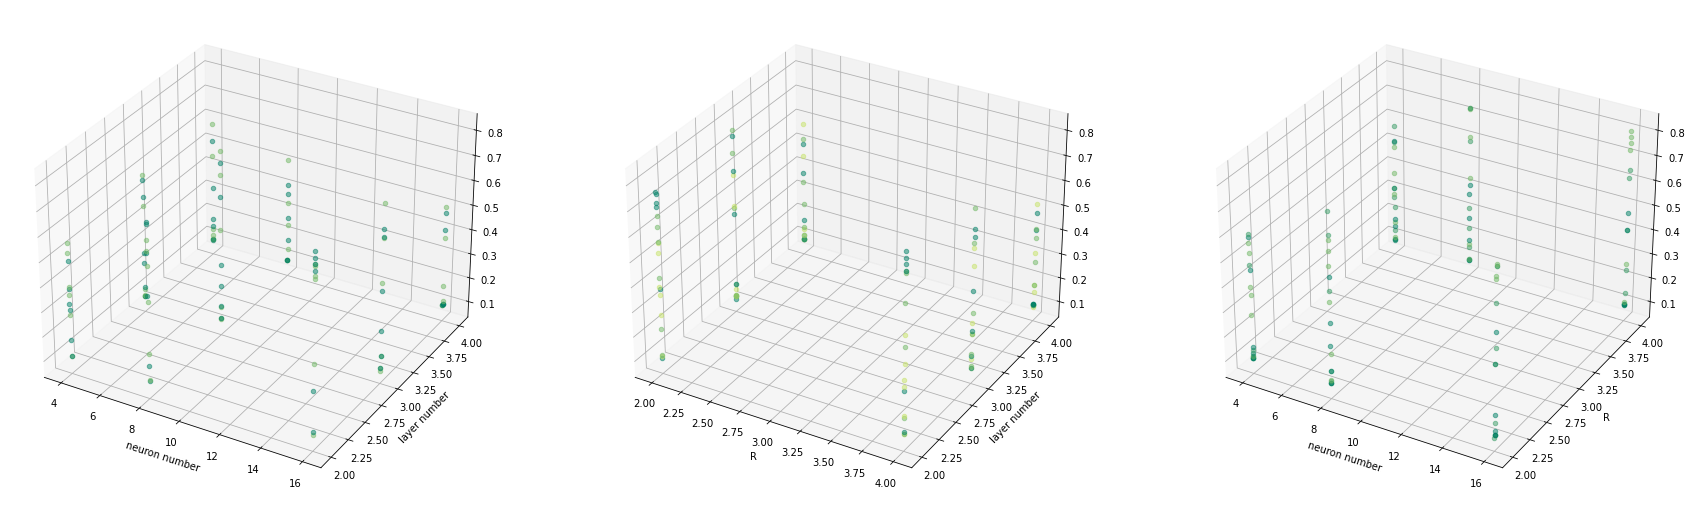

In [9]:
plot_accuracy_multi_param(scores, parameters)

0.8125 [2, 4, 4000.0, 16]


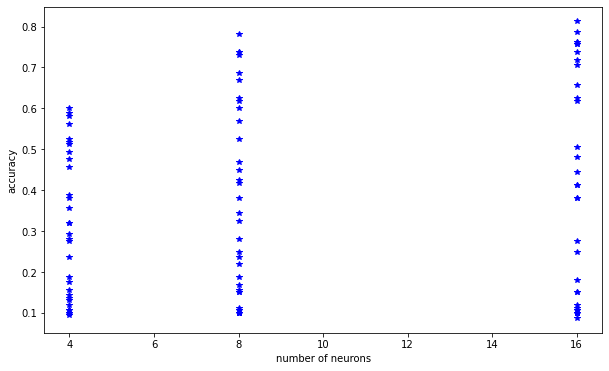

In [19]:
plot_accuracy(scores, parameters, 3)

## Parameter tuning

In [6]:
transform = tonic.transforms.NumpyAsType(int)
trainset = tonic.datasets.NMNIST(save_to='../../Data/', train=True, transform=transform, first_saccade_only=True)
testset = tonic.datasets.NMNIST(save_to='../../Data/', train=False, transform=transform, first_saccade_only=True)

name = 'homeohots'
homeo = True
timestr = '2022-04-22'
dataset_name = 'nmnist'

R_first = (2, 4)
N_layers = (2,3,4)
n_first = (4,8,16)
tau_first = (.5e3,1e3,2e3,3e3,4e3,5e3)

parameters = []
scores = []

for lay in N_layers:
    for R in R_first:
        for tau in tau_first:
            for N_neuron in n_first:
                Rz = [R*2**Nl for Nl in range(lay)]
                N_neuronz = [N_neuron*2**Nl for Nl in range(lay)]
                N_pola = N_neuronz.copy()
                N_pola.insert(0,2)
                tauz = [tau*N_pola[Nl+1]/N_pola[Nl] for Nl in range(lay-1)]
                tauz.insert(0,tau*2)
                hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo)
                filtering_threshold = [2*Rz[L] for L in range(len(Rz))]
                #clustering
                loader = get_loader(trainset, kfold = 300)
                hots.clustering(loader, trainset.ordering, filtering_threshold)
                #training
                loader = get_loader(trainset, kfold = 60)
                num_sample_train = len(loader)
                hots.coding(loader, trainset.ordering, trainset.classes, filtering_threshold, training=True)
                #testing
                loader = get_loader(testset, kfold = 60)
                num_sample_test = len(loader)
                hots.coding(loader, trainset.ordering, trainset.classes, filtering_threshold, training=False)
                jitter = (None, None)
                
                train_path = f'../Records/output/train/{hots.name}_{num_sample_train}_{jitter}/'
                test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'

                testset_output = HOTS_Dataset(test_path, trainset.sensor_size, transform=tonic.transforms.NumpyAsType(int))
                trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, transform=tonic.transforms.NumpyAsType(int))
                
                score = make_histogram_classification(trainset_output, testset_output, N_neuronz[-1])
                print(f' Accuracy: {score*100}%')
                
                parameters.append([lay, R, tau, N_neuron])
                scores.append(score)

this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[4, 8]_[1000.0, 1000.0]_[2, 4]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[4, 8]_[1000.0, 1000.0]_[2, 4]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 923.58it/s]


 Accuracy: 10.625%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[8, 16]_[1000.0, 2000.0]_[2, 4]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[8, 16]_[1000.0, 2000.0]_[2, 4]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 886.41it/s]


 Accuracy: 11.25%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32]_[1000.0, 4000.0]_[2, 4]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32]_[1000.0, 4000.0]_[2, 4]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 848.40it/s]


 Accuracy: 10.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[4, 8]_[2000.0, 2000.0]_[2, 4]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[4, 8]_[2000.0, 2000.0]_[2, 4]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 797.00it/s]


 Accuracy: 27.500000000000004%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[8, 16]_[2000.0, 4000.0]_[2, 4]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[8, 16]_[2000.0, 4000.0]_[2, 4]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 784.00it/s]


 Accuracy: 21.875%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32]_[2000.0, 8000.0]_[2, 4]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32]_[2000.0, 8000.0]_[2, 4]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 784.66it/s]


 Accuracy: 38.125%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[4, 8]_[4000.0, 4000.0]_[2, 4]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[4, 8]_[4000.0, 4000.0]_[2, 4]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 781.29it/s]


 Accuracy: 35.625%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[8, 16]_[4000.0, 8000.0]_[2, 4]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[8, 16]_[4000.0, 8000.0]_[2, 4]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 783.83it/s]


 Accuracy: 42.5%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32]_[4000.0, 16000.0]_[2, 4]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32]_[4000.0, 16000.0]_[2, 4]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 771.71it/s]


 Accuracy: 70.625%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[4, 8]_[6000.0, 6000.0]_[2, 4]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[4, 8]_[6000.0, 6000.0]_[2, 4]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 776.52it/s]


 Accuracy: 38.75%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[8, 16]_[6000.0, 12000.0]_[2, 4]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[8, 16]_[6000.0, 12000.0]_[2, 4]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 758.22it/s]


 Accuracy: 56.875%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32]_[6000.0, 24000.0]_[2, 4]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32]_[6000.0, 24000.0]_[2, 4]_160_(None, None)/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 1482.53it/s]


 Accuracy: 75.625%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[4, 8]_[8000.0, 8000.0]_[2, 4]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[4, 8]_[8000.0, 8000.0]_[2, 4]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 783.02it/s]


 Accuracy: 52.5%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[8, 16]_[8000.0, 16000.0]_[2, 4]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[8, 16]_[8000.0, 16000.0]_[2, 4]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 781.48it/s]


 Accuracy: 62.5%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32]_[8000.0, 32000.0]_[2, 4]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32]_[8000.0, 32000.0]_[2, 4]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 778.92it/s]


 Accuracy: 71.875%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[4, 8]_[10000.0, 10000.0]_[2, 4]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[4, 8]_[10000.0, 10000.0]_[2, 4]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 777.35it/s]


 Accuracy: 56.25%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[8, 16]_[10000.0, 20000.0]_[2, 4]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[8, 16]_[10000.0, 20000.0]_[2, 4]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 765.53it/s]


 Accuracy: 66.875%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32]_[10000.0, 40000.0]_[2, 4]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32]_[10000.0, 40000.0]_[2, 4]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 782.79it/s]


 Accuracy: 76.25%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[4, 8]_[1000.0, 1000.0]_[4, 8]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[4, 8]_[1000.0, 1000.0]_[4, 8]_160_(None, None)/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 1009.01it/s]


 Accuracy: 10.625%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[8, 16]_[1000.0, 2000.0]_[4, 8]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[8, 16]_[1000.0, 2000.0]_[4, 8]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 891.51it/s]


 Accuracy: 10.625%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32]_[1000.0, 4000.0]_[4, 8]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32]_[1000.0, 4000.0]_[4, 8]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 857.76it/s]


 Accuracy: 11.25%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[4, 8]_[2000.0, 2000.0]_[4, 8]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[4, 8]_[2000.0, 2000.0]_[4, 8]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 804.07it/s]


 Accuracy: 17.5%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[8, 16]_[2000.0, 4000.0]_[4, 8]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[8, 16]_[2000.0, 4000.0]_[4, 8]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 798.39it/s]


 Accuracy: 16.875%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32]_[2000.0, 8000.0]_[4, 8]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32]_[2000.0, 8000.0]_[4, 8]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 795.05it/s]


 Accuracy: 27.500000000000004%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[4, 8]_[4000.0, 4000.0]_[4, 8]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[4, 8]_[4000.0, 4000.0]_[4, 8]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 728.28it/s]


 Accuracy: 29.375%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[8, 16]_[4000.0, 8000.0]_[4, 8]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[8, 16]_[4000.0, 8000.0]_[4, 8]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 784.38it/s]


 Accuracy: 45.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32]_[4000.0, 16000.0]_[4, 8]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32]_[4000.0, 16000.0]_[4, 8]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 790.19it/s]


 Accuracy: 76.25%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[4, 8]_[6000.0, 6000.0]_[4, 8]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[4, 8]_[6000.0, 6000.0]_[4, 8]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 785.06it/s]


 Accuracy: 31.874999999999996%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[8, 16]_[6000.0, 12000.0]_[4, 8]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[8, 16]_[6000.0, 12000.0]_[4, 8]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 782.49it/s]


 Accuracy: 61.875%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32]_[6000.0, 24000.0]_[4, 8]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32]_[6000.0, 24000.0]_[4, 8]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 821.88it/s]


 Accuracy: 78.75%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[4, 8]_[8000.0, 8000.0]_[4, 8]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[4, 8]_[8000.0, 8000.0]_[4, 8]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 828.66it/s]


 Accuracy: 38.125%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[8, 16]_[8000.0, 16000.0]_[4, 8]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[8, 16]_[8000.0, 16000.0]_[4, 8]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 827.09it/s]


 Accuracy: 73.125%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32]_[8000.0, 32000.0]_[4, 8]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32]_[8000.0, 32000.0]_[4, 8]_160_(None, None)/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 1336.77it/s]


 Accuracy: 81.25%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[4, 8]_[10000.0, 10000.0]_[4, 8]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[4, 8]_[10000.0, 10000.0]_[4, 8]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 779.83it/s]


 Accuracy: 49.375%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[8, 16]_[10000.0, 20000.0]_[4, 8]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[8, 16]_[10000.0, 20000.0]_[4, 8]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 778.54it/s]


 Accuracy: 73.75%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32]_[10000.0, 40000.0]_[4, 8]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32]_[10000.0, 40000.0]_[4, 8]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 810.05it/s]


 Accuracy: 73.75%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[4, 8, 16]_[1000.0, 1000.0, 1000.0]_[2, 4, 8]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[4, 8, 16]_[1000.0, 1000.0, 1000.0]_[2, 4, 8]_160_(None, None)/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 1474.20it/s]


 Accuracy: 10.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[8, 16, 32]_[1000.0, 2000.0, 1000.0]_[2, 4, 8]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[8, 16, 32]_[1000.0, 2000.0, 1000.0]_[2, 4, 8]_160_(None, None)/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 1250.34it/s]


 Accuracy: 10.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32, 64]_[1000.0, 4000.0, 1000.0]_[2, 4, 8]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32, 64]_[1000.0, 4000.0, 1000.0]_[2, 4, 8]_160_(None, None)/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 1141.99it/s]


 Accuracy: 10.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[4, 8, 16]_[2000.0, 2000.0, 2000.0]_[2, 4, 8]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[4, 8, 16]_[2000.0, 2000.0, 2000.0]_[2, 4, 8]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 834.26it/s]


 Accuracy: 10.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[8, 16, 32]_[2000.0, 4000.0, 2000.0]_[2, 4, 8]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[8, 16, 32]_[2000.0, 4000.0, 2000.0]_[2, 4, 8]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 829.99it/s]


 Accuracy: 15.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32, 64]_[2000.0, 8000.0, 2000.0]_[2, 4, 8]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32, 64]_[2000.0, 8000.0, 2000.0]_[2, 4, 8]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 832.56it/s]


 Accuracy: 15.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[4, 8, 16]_[4000.0, 4000.0, 4000.0]_[2, 4, 8]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[4, 8, 16]_[4000.0, 4000.0, 4000.0]_[2, 4, 8]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 789.99it/s]


 Accuracy: 10.625%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[8, 16, 32]_[4000.0, 8000.0, 4000.0]_[2, 4, 8]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[8, 16, 32]_[4000.0, 8000.0, 4000.0]_[2, 4, 8]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 787.14it/s]


 Accuracy: 10.625%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32, 64]_[4000.0, 16000.0, 4000.0]_[2, 4, 8]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32, 64]_[4000.0, 16000.0, 4000.0]_[2, 4, 8]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 773.54it/s]


 Accuracy: 8.75%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[4, 8, 16]_[6000.0, 6000.0, 6000.0]_[2, 4, 8]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[4, 8, 16]_[6000.0, 6000.0, 6000.0]_[2, 4, 8]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 787.31it/s]


 Accuracy: 13.125%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[8, 16, 32]_[6000.0, 12000.0, 6000.0]_[2, 4, 8]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[8, 16, 32]_[6000.0, 12000.0, 6000.0]_[2, 4, 8]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 786.27it/s]


 Accuracy: 46.875%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32, 64]_[6000.0, 24000.0, 6000.0]_[2, 4, 8]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32, 64]_[6000.0, 24000.0, 6000.0]_[2, 4, 8]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 786.64it/s]


 Accuracy: 44.375%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[4, 8, 16]_[8000.0, 8000.0, 8000.0]_[2, 4, 8]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[4, 8, 16]_[8000.0, 8000.0, 8000.0]_[2, 4, 8]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 784.77it/s]


 Accuracy: 47.5%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[8, 16, 32]_[8000.0, 16000.0, 8000.0]_[2, 4, 8]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[8, 16, 32]_[8000.0, 16000.0, 8000.0]_[2, 4, 8]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 781.23it/s]


 Accuracy: 68.75%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32, 64]_[8000.0, 32000.0, 8000.0]_[2, 4, 8]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32, 64]_[8000.0, 32000.0, 8000.0]_[2, 4, 8]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 783.88it/s]


 Accuracy: 61.875%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[4, 8, 16]_[10000.0, 10000.0, 10000.0]_[2, 4, 8]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[4, 8, 16]_[10000.0, 10000.0, 10000.0]_[2, 4, 8]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 787.38it/s]


 Accuracy: 60.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[8, 16, 32]_[10000.0, 20000.0, 10000.0]_[2, 4, 8]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[8, 16, 32]_[10000.0, 20000.0, 10000.0]_[2, 4, 8]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 784.35it/s]


 Accuracy: 78.125%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32, 64]_[10000.0, 40000.0, 10000.0]_[2, 4, 8]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32, 64]_[10000.0, 40000.0, 10000.0]_[2, 4, 8]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 809.95it/s]


 Accuracy: 75.625%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[4, 8, 16]_[1000.0, 1000.0, 1000.0]_[4, 8, 16]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[4, 8, 16]_[1000.0, 1000.0, 1000.0]_[4, 8, 16]_160_(None, None)/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 1263.94it/s]


 Accuracy: 10.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[8, 16, 32]_[1000.0, 2000.0, 1000.0]_[4, 8, 16]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[8, 16, 32]_[1000.0, 2000.0, 1000.0]_[4, 8, 16]_160_(None, None)/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 1238.37it/s]


 Accuracy: 10.625%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32, 64]_[1000.0, 4000.0, 1000.0]_[4, 8, 16]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32, 64]_[1000.0, 4000.0, 1000.0]_[4, 8, 16]_160_(None, None)/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 1234.52it/s]


 Accuracy: 10.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[4, 8, 16]_[2000.0, 2000.0, 2000.0]_[4, 8, 16]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[4, 8, 16]_[2000.0, 2000.0, 2000.0]_[4, 8, 16]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 832.41it/s]


 Accuracy: 13.750000000000002%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[8, 16, 32]_[2000.0, 4000.0, 2000.0]_[4, 8, 16]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[8, 16, 32]_[2000.0, 4000.0, 2000.0]_[4, 8, 16]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 866.36it/s]


 Accuracy: 15.625%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32, 64]_[2000.0, 8000.0, 2000.0]_[4, 8, 16]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32, 64]_[2000.0, 8000.0, 2000.0]_[4, 8, 16]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 861.67it/s]


 Accuracy: 15.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[4, 8, 16]_[4000.0, 4000.0, 4000.0]_[4, 8, 16]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[4, 8, 16]_[4000.0, 4000.0, 4000.0]_[4, 8, 16]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 798.47it/s]


 Accuracy: 23.75%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[8, 16, 32]_[4000.0, 8000.0, 4000.0]_[4, 8, 16]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[8, 16, 32]_[4000.0, 8000.0, 4000.0]_[4, 8, 16]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 768.93it/s]


 Accuracy: 23.75%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32, 64]_[4000.0, 16000.0, 4000.0]_[4, 8, 16]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32, 64]_[4000.0, 16000.0, 4000.0]_[4, 8, 16]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 779.32it/s]


 Accuracy: 25.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[4, 8, 16]_[6000.0, 6000.0, 6000.0]_[4, 8, 16]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[4, 8, 16]_[6000.0, 6000.0, 6000.0]_[4, 8, 16]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 779.63it/s]


 Accuracy: 28.125%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[8, 16, 32]_[6000.0, 12000.0, 6000.0]_[4, 8, 16]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[8, 16, 32]_[6000.0, 12000.0, 6000.0]_[4, 8, 16]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 787.21it/s]


 Accuracy: 32.5%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32, 64]_[6000.0, 24000.0, 6000.0]_[4, 8, 16]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32, 64]_[6000.0, 24000.0, 6000.0]_[4, 8, 16]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 788.30it/s]


 Accuracy: 41.25%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[4, 8, 16]_[8000.0, 8000.0, 8000.0]_[4, 8, 16]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[4, 8, 16]_[8000.0, 8000.0, 8000.0]_[4, 8, 16]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 765.16it/s]


 Accuracy: 51.24999999999999%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[8, 16, 32]_[8000.0, 16000.0, 8000.0]_[4, 8, 16]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[8, 16, 32]_[8000.0, 16000.0, 8000.0]_[4, 8, 16]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 759.33it/s]


 Accuracy: 60.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32, 64]_[8000.0, 32000.0, 8000.0]_[4, 8, 16]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32, 64]_[8000.0, 32000.0, 8000.0]_[4, 8, 16]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 760.21it/s]


 Accuracy: 62.5%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[4, 8, 16]_[10000.0, 10000.0, 10000.0]_[4, 8, 16]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[4, 8, 16]_[10000.0, 10000.0, 10000.0]_[4, 8, 16]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 783.30it/s]


 Accuracy: 58.12500000000001%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[8, 16, 32]_[10000.0, 20000.0, 10000.0]_[4, 8, 16]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[8, 16, 32]_[10000.0, 20000.0, 10000.0]_[4, 8, 16]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 782.49it/s]


 Accuracy: 73.75%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32, 64]_[10000.0, 40000.0, 10000.0]_[4, 8, 16]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32, 64]_[10000.0, 40000.0, 10000.0]_[4, 8, 16]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 809.02it/s]


 Accuracy: 65.625%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[4, 8, 16, 32]_[1000.0, 1000.0, 1000.0, 1000.0]_[2, 4, 8, 16]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[4, 8, 16, 32]_[1000.0, 1000.0, 1000.0, 1000.0]_[2, 4, 8, 16]_160_(None, None)/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 1407.49it/s]


 Accuracy: 10.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[8, 16, 32, 64]_[1000.0, 2000.0, 1000.0, 1000.0]_[2, 4, 8, 16]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[8, 16, 32, 64]_[1000.0, 2000.0, 1000.0, 1000.0]_[2, 4, 8, 16]_160_(None, None)/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 1465.31it/s]


 Accuracy: 10.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32, 64, 128]_[1000.0, 4000.0, 1000.0, 1000.0]_[2, 4, 8, 16]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32, 64, 128]_[1000.0, 4000.0, 1000.0, 1000.0]_[2, 4, 8, 16]_160_(None, None)/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 1382.08it/s]


 Accuracy: 10.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[4, 8, 16, 32]_[2000.0, 2000.0, 2000.0, 2000.0]_[2, 4, 8, 16]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[4, 8, 16, 32]_[2000.0, 2000.0, 2000.0, 2000.0]_[2, 4, 8, 16]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 995.39it/s]


 Accuracy: 10.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[8, 16, 32, 64]_[2000.0, 4000.0, 2000.0, 2000.0]_[2, 4, 8, 16]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[8, 16, 32, 64]_[2000.0, 4000.0, 2000.0, 2000.0]_[2, 4, 8, 16]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 916.10it/s]


 Accuracy: 10.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32, 64, 128]_[2000.0, 8000.0, 2000.0, 2000.0]_[2, 4, 8, 16]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32, 64, 128]_[2000.0, 8000.0, 2000.0, 2000.0]_[2, 4, 8, 16]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 910.54it/s]


 Accuracy: 10.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[4, 8, 16, 32]_[4000.0, 4000.0, 4000.0, 4000.0]_[2, 4, 8, 16]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[4, 8, 16, 32]_[4000.0, 4000.0, 4000.0, 4000.0]_[2, 4, 8, 16]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 820.95it/s]


 Accuracy: 14.374999999999998%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[8, 16, 32, 64]_[4000.0, 8000.0, 4000.0, 4000.0]_[2, 4, 8, 16]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[8, 16, 32, 64]_[4000.0, 8000.0, 4000.0, 4000.0]_[2, 4, 8, 16]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 810.60it/s]


 Accuracy: 15.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32, 64, 128]_[4000.0, 16000.0, 4000.0, 4000.0]_[2, 4, 8, 16]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32, 64, 128]_[4000.0, 16000.0, 4000.0, 4000.0]_[2, 4, 8, 16]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 808.95it/s]


 Accuracy: 11.875%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[4, 8, 16, 32]_[6000.0, 6000.0, 6000.0, 6000.0]_[2, 4, 8, 16]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[4, 8, 16, 32]_[6000.0, 6000.0, 6000.0, 6000.0]_[2, 4, 8, 16]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 797.81it/s]


 Accuracy: 11.875%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[8, 16, 32, 64]_[6000.0, 12000.0, 6000.0, 6000.0]_[2, 4, 8, 16]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[8, 16, 32, 64]_[6000.0, 12000.0, 6000.0, 6000.0]_[2, 4, 8, 16]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 763.12it/s]


 Accuracy: 25.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32, 64, 128]_[6000.0, 24000.0, 6000.0, 6000.0]_[2, 4, 8, 16]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32, 64, 128]_[6000.0, 24000.0, 6000.0, 6000.0]_[2, 4, 8, 16]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 778.43it/s]


 Accuracy: 18.125%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[4, 8, 16, 32]_[8000.0, 8000.0, 8000.0, 8000.0]_[2, 4, 8, 16]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[4, 8, 16, 32]_[8000.0, 8000.0, 8000.0, 8000.0]_[2, 4, 8, 16]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 775.93it/s]


 Accuracy: 45.625%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[8, 16, 32, 64]_[8000.0, 16000.0, 8000.0, 8000.0]_[2, 4, 8, 16]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[8, 16, 32, 64]_[8000.0, 16000.0, 8000.0, 8000.0]_[2, 4, 8, 16]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 801.73it/s]


 Accuracy: 34.375%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32, 64, 128]_[8000.0, 32000.0, 8000.0, 8000.0]_[2, 4, 8, 16]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32, 64, 128]_[8000.0, 32000.0, 8000.0, 8000.0]_[2, 4, 8, 16]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 781.68it/s]


 Accuracy: 38.125%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[4, 8, 16, 32]_[10000.0, 10000.0, 10000.0, 10000.0]_[2, 4, 8, 16]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[4, 8, 16, 32]_[10000.0, 10000.0, 10000.0, 10000.0]_[2, 4, 8, 16]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 770.47it/s]


 Accuracy: 58.75%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[8, 16, 32, 64]_[10000.0, 20000.0, 10000.0, 10000.0]_[2, 4, 8, 16]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[8, 16, 32, 64]_[10000.0, 20000.0, 10000.0, 10000.0]_[2, 4, 8, 16]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 787.32it/s]


 Accuracy: 52.5%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32, 64, 128]_[10000.0, 40000.0, 10000.0, 10000.0]_[2, 4, 8, 16]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32, 64, 128]_[10000.0, 40000.0, 10000.0, 10000.0]_[2, 4, 8, 16]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 964.06it/s]


 Accuracy: 50.625%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[4, 8, 16, 32]_[1000.0, 1000.0, 1000.0, 1000.0]_[4, 8, 16, 32]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[4, 8, 16, 32]_[1000.0, 1000.0, 1000.0, 1000.0]_[4, 8, 16, 32]_160_(None, None)/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 1309.65it/s]


 Accuracy: 10.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[8, 16, 32, 64]_[1000.0, 2000.0, 1000.0, 1000.0]_[4, 8, 16, 32]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[8, 16, 32, 64]_[1000.0, 2000.0, 1000.0, 1000.0]_[4, 8, 16, 32]_160_(None, None)/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 1450.85it/s]


 Accuracy: 10.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32, 64, 128]_[1000.0, 4000.0, 1000.0, 1000.0]_[4, 8, 16, 32]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32, 64, 128]_[1000.0, 4000.0, 1000.0, 1000.0]_[4, 8, 16, 32]_160_(None, None)/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 1328.29it/s]


 Accuracy: 10.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[4, 8, 16, 32]_[2000.0, 2000.0, 2000.0, 2000.0]_[4, 8, 16, 32]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[4, 8, 16, 32]_[2000.0, 2000.0, 2000.0, 2000.0]_[4, 8, 16, 32]_160_(None, None)/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 1175.07it/s]


 Accuracy: 9.375%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[8, 16, 32, 64]_[2000.0, 4000.0, 2000.0, 2000.0]_[4, 8, 16, 32]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[8, 16, 32, 64]_[2000.0, 4000.0, 2000.0, 2000.0]_[4, 8, 16, 32]_160_(None, None)/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 1159.95it/s]


 Accuracy: 10.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32, 64, 128]_[2000.0, 8000.0, 2000.0, 2000.0]_[4, 8, 16, 32]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32, 64, 128]_[2000.0, 8000.0, 2000.0, 2000.0]_[4, 8, 16, 32]_160_(None, None)/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 1154.54it/s]


 Accuracy: 10.625%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[4, 8, 16, 32]_[4000.0, 4000.0, 4000.0, 4000.0]_[4, 8, 16, 32]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[4, 8, 16, 32]_[4000.0, 4000.0, 4000.0, 4000.0]_[4, 8, 16, 32]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 867.75it/s]


 Accuracy: 18.75%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[8, 16, 32, 64]_[4000.0, 8000.0, 4000.0, 4000.0]_[4, 8, 16, 32]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[8, 16, 32, 64]_[4000.0, 8000.0, 4000.0, 4000.0]_[4, 8, 16, 32]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 859.35it/s]


 Accuracy: 18.75%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32, 64, 128]_[4000.0, 16000.0, 4000.0, 4000.0]_[4, 8, 16, 32]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32, 64, 128]_[4000.0, 16000.0, 4000.0, 4000.0]_[4, 8, 16, 32]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 865.24it/s]


 Accuracy: 10.625%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[4, 8, 16, 32]_[6000.0, 6000.0, 6000.0, 6000.0]_[4, 8, 16, 32]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[4, 8, 16, 32]_[6000.0, 6000.0, 6000.0, 6000.0]_[4, 8, 16, 32]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 826.31it/s]


 Accuracy: 15.625%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[8, 16, 32, 64]_[6000.0, 12000.0, 6000.0, 6000.0]_[4, 8, 16, 32]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[8, 16, 32, 64]_[6000.0, 12000.0, 6000.0, 6000.0]_[4, 8, 16, 32]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 788.27it/s]


 Accuracy: 38.125%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32, 64, 128]_[6000.0, 24000.0, 6000.0, 6000.0]_[4, 8, 16, 32]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32, 64, 128]_[6000.0, 24000.0, 6000.0, 6000.0]_[4, 8, 16, 32]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 819.98it/s]


 Accuracy: 10.625%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[4, 8, 16, 32]_[8000.0, 8000.0, 8000.0, 8000.0]_[4, 8, 16, 32]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[4, 8, 16, 32]_[8000.0, 8000.0, 8000.0, 8000.0]_[4, 8, 16, 32]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 814.80it/s]


 Accuracy: 31.874999999999996%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[8, 16, 32, 64]_[8000.0, 16000.0, 8000.0, 8000.0]_[4, 8, 16, 32]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[8, 16, 32, 64]_[8000.0, 16000.0, 8000.0, 8000.0]_[4, 8, 16, 32]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 846.77it/s]


 Accuracy: 28.125%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32, 64, 128]_[8000.0, 32000.0, 8000.0, 8000.0]_[4, 8, 16, 32]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32, 64, 128]_[8000.0, 32000.0, 8000.0, 8000.0]_[4, 8, 16, 32]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 786.47it/s]


 Accuracy: 48.125%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[4, 8, 16, 32]_[10000.0, 10000.0, 10000.0, 10000.0]_[4, 8, 16, 32]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[4, 8, 16, 32]_[10000.0, 10000.0, 10000.0, 10000.0]_[4, 8, 16, 32]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 818.12it/s]


 Accuracy: 51.87500000000001%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[8, 16, 32, 64]_[10000.0, 20000.0, 10000.0, 10000.0]_[4, 8, 16, 32]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[8, 16, 32, 64]_[10000.0, 20000.0, 10000.0, 10000.0]_[4, 8, 16, 32]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 831.89it/s]


 Accuracy: 41.875%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_nmnist_homeohots_True_[16, 32, 64, 128]_[10000.0, 40000.0, 10000.0, 10000.0]_[4, 8, 16, 32]_1000_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_nmnist_homeohots_True_[16, 32, 64, 128]_[10000.0, 40000.0, 10000.0, 10000.0]_[4, 8, 16, 32]_160_(None, None)/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 776.23it/s]

 Accuracy: 41.25%


### Choice of an architecture
Initial choice is to have an increased number of neurons with 3 layers. 

In [ ]:
name = 'homeohots'
homeo = True
timestr = '2022-04-22'
dataset_name = 'nmnist'

Rz = (2, 4)
N_neuronz = (8, 16)
tauz = (5e3, 5e3*8/2)

network = network(name, dataset_name, timestr, dataset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo)

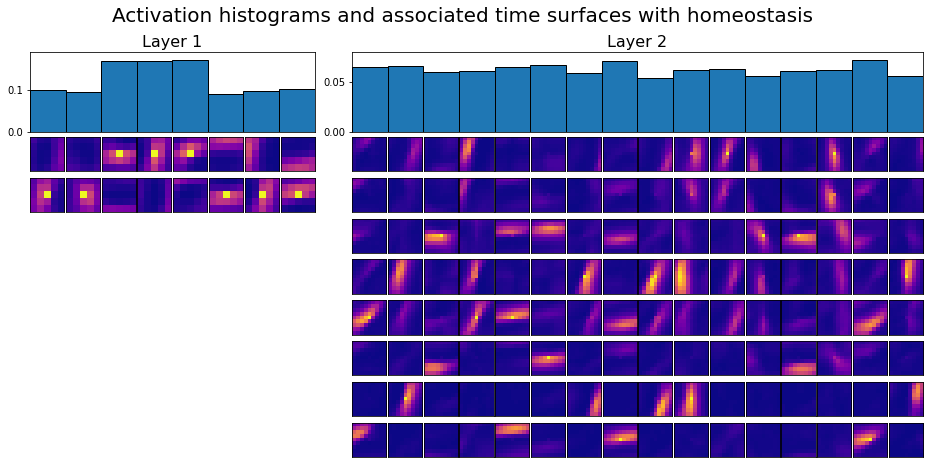

In [14]:
if not os.path.exists('../Records/'):
    os.mkdir('../Records/')
    os.mkdir('../Records/networks/')
filtering_threshold = [2*Rz[L] for L in range(len(Rz))]
path = '../Records/networks/'+network.name+'.pkl'
if not os.path.exists(path):
    network.clustering(loader, dataset.ordering, filtering_threshold)
network.plotlayers();

In [9]:
loader = get_loader(dataset, kfold = None, shuffle=True)
num_sample_train = len(dataset)
network.coding(loader, dataset.ordering, dataset.classes, filtering_threshold, training=True)

TypeError: coding() missing 1 required positional argument: 'filtering_threshold'

In [ ]:
dataset = tonic.datasets.POKERDVS(save_to='../../Data/', train=False, transform=transform)
num_sample_test = len(dataset)
loader = get_loader(dataset, kfold = None, shuffle=True)
network.coding(loader, dataset.ordering, dataset.classes, filtering_threshold, training=False)

In [ ]:
from utils import make_histogram_classification, HOTS_Dataset
jitter = (None, None)

train_path = f'../Records/output/train/{network.name}_{num_sample_train}_{jitter}/'
test_path = f'../Records/output/test/{network.name}_{num_sample_test}_{jitter}/'

testset = HOTS_Dataset(test_path, dataset.sensor_size, transform=tonic.transforms.NumpyAsType(int))
trainset = HOTS_Dataset(train_path, dataset.sensor_size, transform=tonic.transforms.NumpyAsType(int))

In [ ]:
score = make_histogram_classification(trainset, testset, N_neuronz[-1]) 
print(f' Accuracy: {score*100}%')